In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model,save_model,load_model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout,Input,Flatten
from glob import glob

In [11]:
data_dir =r"E:\1. Thesis\Update_Code\Dataset"
keyword= ['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

In [12]:
class_folders=os.listdir(data_dir)
image_paths=[]
labels=[]

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
                class_path=os.path.join(data_dir,class_folder)
                image_files=os.listdir(class_path)
                for image_file in image_files:
                    image_path=os.path.join(class_path,image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    
df=pd.DataFrame({'image_path':image_paths,'label':labels})
print("The classes:",np.unique(df['label']))

class_counts=df['label'].value_counts()
class_counts

The classes: ['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']


label
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: count, dtype: int64

In [13]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [14]:
def load_images_for_cnn(train_df, 
                        val_df, 
                        test_df, 
                        batch_size=32, 
                        target_size=(224,224)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        #horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df,
                                                                        val_df, 
                                                                        test_df, 
                                                                        batch_size=32, 
                                                                        target_size=(224,224))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [18]:
base_model = ResNet152V2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable=False
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation='relu')(x)
predictions=Dense(8,activation='softmax')(x)

model = Model(inputs=base_model.input,outputs=predictions)  #Create model
model.compile(optimizer=Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
epochs=10
history=model.fit(train_generator,epochs=epochs,validation_data=validation_generator)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 990s 13s/step - accuracy: 0.2765 - loss: 2.0556 - val_accuracy: 0.6112 - val_loss: 1.2899
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 874s 12s/step - accuracy: 0.6816 - loss: 1.1948 - val_accuracy: 0.7688 - val_loss: 0.8549
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 892s 12s/step - accuracy: 0.7946 - loss: 0.8371 - val_accuracy: 0.8213 - val_loss: 0.6383
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 889s 12s/step - accuracy: 0.8512 - loss: 0.6641 - val_accuracy: 0.8650 - val_loss: 0.5100
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 897s 12s/step - accuracy: 0.8848 - loss: 0.5117 - val_accuracy: 0.8900 - val_loss: 0.4252
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 893s 12s/step - accuracy: 0.9126 - loss: 0.4326 - val_accuracy: 0.9137 - val_loss: 0.3609
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 891s 12s/step - accuracy: 0.9191 - loss: 0.3908 - val_accuracy: 0.9237 - val_loss: 0.3182
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 890s 12s/step - accuracy: 0.9230 - loss: 0.3369 - val_accuracy: 0.

In [20]:
test_loss,test_accuracy=model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 242s 10s/step - accuracy: 0.9304 - loss: 0.2539
Test Loss: 0.236847922205925, Test Accuracy: 0.9387500286102295


In [21]:
predictions=model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 251s 9s/step
                  precision    recall  f1-score   support

     Anthracnose       0.93      0.97      0.95       117
Bacterial Canker       0.99      0.96      0.98       109
  Cutting Weevil       1.00      1.00      1.00       104
        Die Back       0.98      0.96      0.97        97
      Gall Midge       0.93      0.92      0.92       107
         Healthy       0.89      0.97      0.93        77
  Powdery Mildew       0.88      0.88      0.88        98
     Sooty Mould       0.90      0.85      0.87        91

        accuracy                           0.94       800
       macro avg       0.94      0.94      0.94       800
    weighted avg       0.94      0.94      0.94       800



In [22]:
test_predictions=model.predict(test_generator)
test_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 225s 9s/step


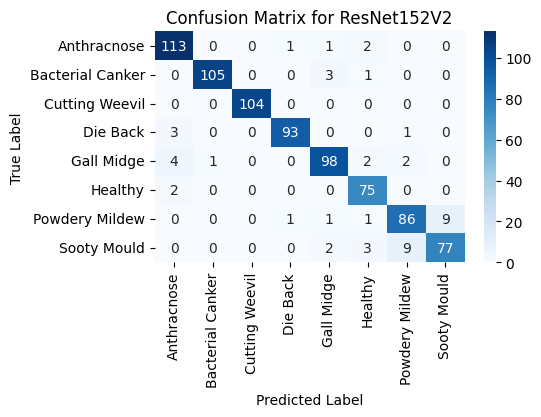

In [27]:
plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,test_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for ResNet152V2')
plt.show()

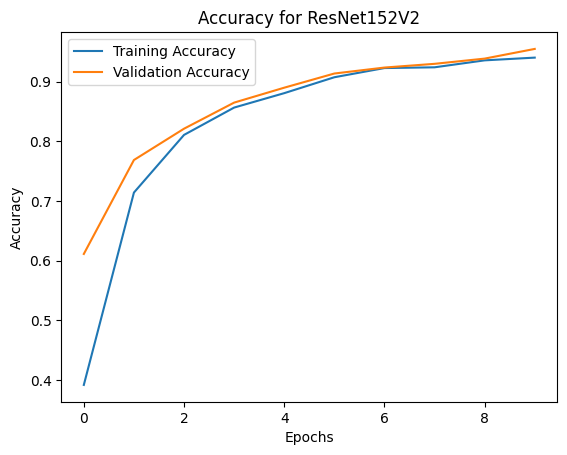

In [28]:
#plot training and validation accuracy
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for ResNet152V2')
plt.legend()
plt.show()

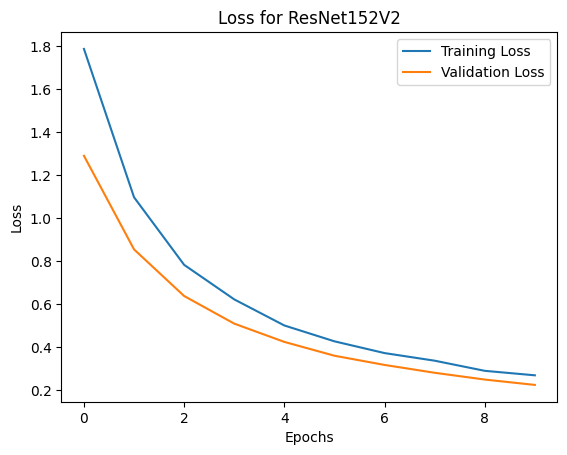

In [29]:
#plot training and validation loss
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for ResNet152V2')
plt.legend()
plt.show()

In [26]:
model.save(r'E:\1. Thesis\Update_Code\SavedModel\ResNet152V2.hdf5')